## Notebook Purpose

Previously was backpropagating on k-space using mse as loss function. This places very high emphasis on low frequency components.

--> How would IQ vary if we applied transforms to emphasize high-frequency components of k-space?

##### Scaling pixel/k-space values?
- Current scaling method:
    - create net_input ~U[0,1]
    - given randomly generated net, compute out_img
    - given slice_ksp, compute orig_img - i.e. ifft of very small k-space vals
    - scale_factor = norm(out_img) / norm(orig_img)
- FastMRI k-space data magnitude values are very small (pre-scale), w a handful of largest outlier values at 1e-3, but most, i.e. 99.9% are < 1e-5
- Conclusion: Scaling of values in k-space or image space shouldn't matter, i.e. 16-bit floating point precision can handle it regardless. Only want output values to be in same range for computing ssim, psnr, etc.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency, forwardm
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(3)
else:
    dtype = torch.FloatTensor

In [ ]:
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []
ssim_list, psnr_list = [], []

file_id_list = ['1000325', '1000464', '1000273', '1000007']#, '1000537', '1000818']#, \
                #'1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
SCALE_VAL_LIST = [1, 10, 100, 1000]
NUM_ITER = 100
DC_STEP = False

NUM_RUNS = 8


for idx, file_id in enumerate(file_id_list):  
    print('')
    print('')
    print('file_id: {}'.format(file_id))
    for scale_val in SCALE_VAL_LIST:
        print('')
        print('scale_val: {}'.format(scale_val))
        for _ in range(NUM_RUNS):

            f, slice_ksp = load_h5(file_id) # load full mri measurements
            
            mask, mask2d, mask1d = get_masks(f, slice_ksp) # load mask + variants, M
            mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step

            # initialize net, net input seed, and scale slice_ksp accordingly
            net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
            slice_ksp = scale_val * slice_ksp

            # for dc step - must do this after scaling slice_ksp
            ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]

            # apply mask to measurements for fitting model
            ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)

            net, mse_wrt_ksp, mse_wrt_img = fit(
                ksp_masked=ksp_masked, img_masked=img_masked,
                net=net, net_input=net_input, mask2d=mask2d,
                mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP, alpha=0,#ALPHA,
                img_ls=None, num_iter=NUM_ITER, dtype=dtype)

            img_out = net(net_input.type(dtype))#[0] # estimate image \hat{x} = G(\hat{C})

            out_ksp_masked = forwardm(img_out, mask2d)

            img_dc, img_est = data_consistency(img_out[0], slice_ksp, mask1d)
            img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

            _, _, ssim_, psnr_ = calc_metrics(img_dc, img_gt)

            # save images, metrics
            img_dc_list.append(img_dc)
            img_gt_list.append(img_gt) # could do this once per loop
            mse_wrt_ksp_list.append(mse_wrt_ksp)
            mse_wrt_img_list.append(mse_wrt_img)
            ssim_list.append(ssim_)
            psnr_list.append(psnr_)



file_id: 1000325

scale_val: 1
scale factor 160860.7064655135
scale factor 160655.9249854304
scale factor 162145.45139315585
scale factor 161123.80366872108
scale factor 159633.40155506844
scale factor 161796.30305533472
scale factor 159969.8256809014
scale factor 160705.1556860762

scale_val: 10
scale factor 162791.01671984425
scale factor 159434.92859427736
scale factor 161120.13261659196
scale factor 159578.03537341167
scale factor 163316.4340476324
scale factor 158690.44298086775
scale factor 157768.59681855762
scale factor 159288.03423636293

scale_val: 100
scale factor 163662.1967611514
scale factor 161775.08521875885
scale factor 159847.07391605238
scale factor 161311.0475817773
scale factor 163833.31679907156
scale factor 161257.49578337514
scale factor 162540.19196742072
scale factor 159774.30298797743

scale_val: 1000
scale factor 159829.8590031833
scale factor 162966.13567468768
scale factor 162839.74894983153
scale factor 163202.44301779958
scale factor 159955.4143181745


In [ ]:
list_oi = psnr_list
list_compare = []

for ss in range(len(SCALE_VAL_LIST)):
    print('')
    print('file_id {}'.format(file_id_list[ff]))

    for ff in range(len(file_id_list)):
        print('scale_val {}'.format(SCALE_VAL_LIST[ss]))
 
        list_compare = []

        for rr in range(NUM_RUNS)
        
            val = list_oi[32*ff + 8*ss + rr]
            list_compare.append(val)
     
        list_compare = np.asarray(list_compare)
        print(list_compare.mean(), list_compare.std())

In [3]:
def convert_np_flatten(arr):
    return arr.detach().cpu().numpy().flatten()

ksp_orig, out_ksp_masked = convert_np_flatten(ksp_orig), convert_np_flatten(out_ksp_masked)

In [4]:
np.linalg.norm(img_est)

662.0300228223965

In [5]:
import include.transforms as transform

ksp_tt = transform.to_tensor(slice_ksp)
orig_tt = transform.ifft2(ksp_tt)   # apply ifft get the complex image
orig_imgs_tt = transform.complex_abs(orig_tt)   # compute absolute value to get a real image
orig_img_tt = transform.root_sum_of_squares(orig_imgs_tt, dim=0)
orig_img_np = orig_img_tt.cpu().numpy()

np.linalg.norm(orig_img_np)

1542.6602

In [6]:
ksp_orig.min(), ksp_orig.max(), ksp_orig.mean()

(-169.03912, 174.29456, -4.2347806e-06)

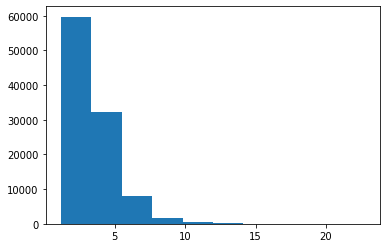

(array([3.0431e+04, 4.2809e+04, 1.6326e+04, 9.2220e+03, 2.4490e+03,
        7.3700e+02, 2.8500e+02, 1.1100e+02, 2.5000e+01, 5.0000e+00]),
 array([ 0.59598503,  1.97162837,  3.34727171,  4.72291506,  6.0985584 ,
         7.47420174,  8.84984509, 10.22548843, 11.60113177, 12.97677512,
        14.35241846]),
 <BarContainer object of 10 artists>)

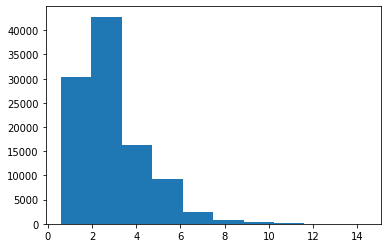

In [14]:
plt.hist(img_gt.flatten())
plt.show()

plt.hist(img_dc.flatten())

In [8]:
img_gt.max(), img_dc.max()

(22.77463658749146, 14.352418461529624)

In [9]:
# new_arr = np.delete(arr, np.where(arr == 2))

slice_ksp_pre = np.absolute(slice_ksp_prescale.flatten())
# slice_ksp_pre = np.delete(slice_ksp_pre, np.where(slice_ksp_pre>0.00013504))

(array([3.570861e+06, 1.980000e+02, 8.000000e+01, 2.500000e+01,
        1.400000e+01, 1.200000e+01, 5.000000e+00, 3.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([0.        , 0.00013504, 0.00027008, 0.00040512, 0.00054016,
        0.0006752 , 0.00081024, 0.00094528, 0.00108032, 0.00121536,
        0.0013504 ], dtype=float32),
 <BarContainer object of 10 artists>)

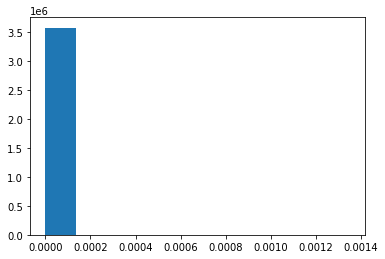

In [10]:
plt.hist(slice_ksp_pre.flatten())

tensor(0.0029, device='cuda:3', grad_fn=<MeanBackward0>) tensor(0.3073, device='cuda:3', grad_fn=<StdBackward0>)


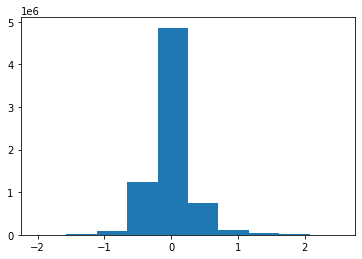

In [15]:
plt.hist(convert_np_flatten(img_out))
print(img_out.mean(), img_out.std())

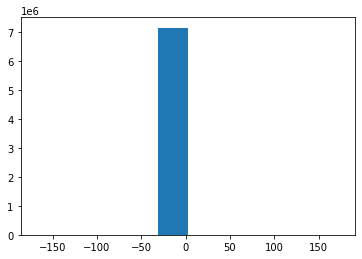

[1.00000e+00 3.00000e+00 2.80000e+01 7.80000e+01 7.13913e+06 3.07400e+03
 5.40000e+01 1.90000e+01 1.10000e+01 2.00000e+00]


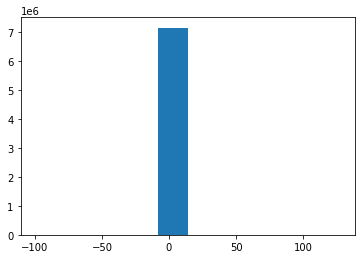

[5.00000e+00 1.40000e+01 4.40000e+01 3.70000e+02 7.14173e+06 1.81000e+02
 3.60000e+01 1.20000e+01 4.00000e+00 4.00000e+00] [-99.26947  -76.5873   -53.90513  -31.22296   -8.54079   14.14138
  36.82355   59.505722  82.18789  104.87006  127.55223 ]


In [18]:
(n, bins, patches) = plt.hist(ksp_orig, bins=10)
plt.show()
print(n)

(n, bins, patches) = plt.hist(out_ksp_masked)
plt.show()
print(n, bins)